### Todo
* correct lat/lon
* calculate all of the same parameters for c2 and add to the dataframe
* save the dataframe using csv and pickle or hdf5
* split the subsample/plotting code into a separate notebook and use picke or hdf5 to load and subsample

* use pictures to evaluat appropriate thresholds for contrast and sharpness
* use similar notebook to evaluate all HoM images and all Marconi images

* subsample with appropriate size, checking distros

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import glob, os

# for tides
from scipy.interpolate import interp1d
import h5py

from coastcam_funcs import *

### Enter site-specific info

In [2]:
station = 'CACO02'
if station == 'CACO01':
    print('Using info for CACO01 - Head of the Meadow')
    tide_file = 'C:/crs/src/CoastCam/data/HoM_ADCIRC_tide_predictions.mat'
    #TODO - relplace these with the official locations
    latitude = 42.05049
    longitude = -70.07734

elif station == 'CACO02':
    print('Using info for CACO02 - Marconi Beach')
    #TODO - relplace these with the official locations
    latitude = 42.05049
    longitude = -70.07734
    tide_file = 'C:/crs/src/CoastCam/data/Marconi_ADCIRC_tide_predictions.mat'

# load tide file
data = h5py.File(tide_file,'r')
T = np.squeeze(np.array(data['T']))
tid = np.squeeze(np.array(data['tid']))

Using info for CACO02 - Marconi Beach


### Work through the folder and find all images pairs

In [3]:
rdir = 'C:/crs/proj/2019_CACO_CoastCam/CACO-02/timex/'
c1list = []
c2list = []

for c1path in glob.glob(rdir+'*c1.timex.jpg'):
    c1file = os.path.basename(c1path)

    # check to see there is a corresponding c2 file
    c2path = rdir+c1file[0:10]+'.c2.timex.jpg'
    if (glob.glob(c2path)):
        c1list.append(c1file)
        c2file = os.path.basename(c2path)
        c2list.append(c2file)
    else:
        print('No match for ',c1file)

nfiles =len( c1list )
print('Found {} pairs.'.format( nfiles ))

No match for  1615240800.c1.timex.jpg
No match for  1618219800.c1.timex.jpg
No match for  1622540790.c1.timex.jpg
No match for  1622543430.c1.timex.jpg
No match for  1622563230.c1.timex.jpg
No match for  1622565030.c1.timex.jpg
No match for  1622566830.c1.timex.jpg
No match for  1622568630.c1.timex.jpg
No match for  1622570430.c1.timex.jpg
No match for  1622572230.c1.timex.jpg
No match for  1622574030.c1.timex.jpg
No match for  1622575830.c1.timex.jpg
No match for  1622577630.c1.timex.jpg
No match for  1622590231.c1.timex.jpg
No match for  1622608230.c1.timex.jpg
No match for  1622655030.c1.timex.jpg
No match for  1622656830.c1.timex.jpg
No match for  1622658630.c1.timex.jpg
No match for  1622660430.c1.timex.jpg
No match for  1622662230.c1.timex.jpg
Found 1776 pairs.


### Work through the list of pairs and use time to calculate sun postion, time relative to local solar noon, and tide.

In [29]:
az = np.nan*np.ones(nfiles)
zen = np.nan*np.ones(nfiles)
dto = np.nan*np.ones(nfiles)
hsn = np.nan*np.ones(nfiles)
dn = np.nan*np.ones(nfiles)
tidi = np.nan*np.ones(nfiles)
doy = np.nan*np.ones(nfiles)

dts_list = []
dto_list = []
for i, fn in enumerate( c1list ):
    dts, dto = filetime2timestr( fn )
    dts_list.append( dts )
    dto_list.append( dto )
    hsn[i] = solar_noon_offset( dts, longitude)

    az[i], zen[i] = sun_az_zen( dts, latitude, longitude )
    dn[i] = datetime2matlabdn( dto )
    doy[i] = dto.timetuple().tm_yday
    tidi[i] = np.interp(dn[i], T, tid)

Text(0, 0.5, 'Tide (m)')

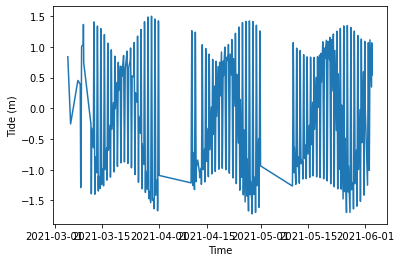

In [5]:
plt.plot( dto_list, tidi )
plt.xlabel('Time')
plt.ylabel('Tide (m)')

### Loop through the files and do cursory image assessment
Estimate sharpness and contrast, and calculate color.
This is much slower because it has to open each file. This is only reading C1...probably should also read C2 as well.

In [6]:
# arrays to store results
sharp = np.nan*np.ones(nfiles)
contrast = np.nan*np.ones(nfiles)
avg = np.nan*np.ones(nfiles)
rgb = np.nan*np.ones((nfiles,3))

for i, fn in enumerate( c1list ):
    with Image.open(rdir+fn) as img:
        sharp[i], contrast[i] = estimate_sharpness( img )
        rgb[i,:], avg[i] = average_color( img )

Text(0, 0.5, 'Average Pixel Intensity')

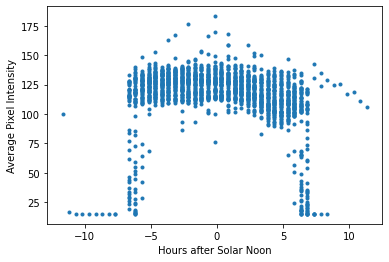

In [13]:
# lludge to fix weird hsn
hsn[hsn<-12]=hsn[hsn<-12]+24.
plt.plot(hsn, avg, '.')
plt.xlabel('Hours after Solar Noon')
plt.ylabel('Average Pixel Intensity')

Text(0.5, 0, 'Tide (m)')

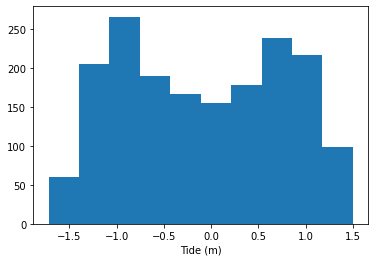

In [17]:
plt.hist(tidi)
plt.xlabel('Tide (m)')

(array([12.,  6., 16.,  3., 12., 17., 47., 81., 59.,  3.]),
 array([-6.39911137, -5.98207891, -5.56504645, -5.148014  , -4.73098154,
        -4.31394908, -3.89691662, -3.47988416, -3.0628517 , -2.64581925,
        -2.22878679]),
 <BarContainer object of 10 artists>)

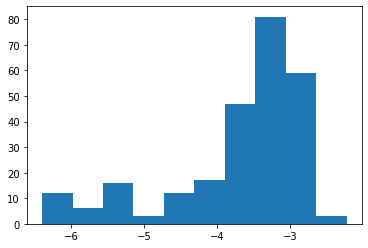

In [24]:
plt.hist(np.log10(sharp[sharp>0]))

(array([12.,  8., 15.,  3., 10.,  9., 23., 31., 60., 85.]),
 array([-3.35007073, -3.06911367, -2.78815661, -2.50719955, -2.22624249,
        -1.94528543, -1.66432837, -1.3833713 , -1.10241424, -0.82145718,
        -0.54050012]),
 <BarContainer object of 10 artists>)

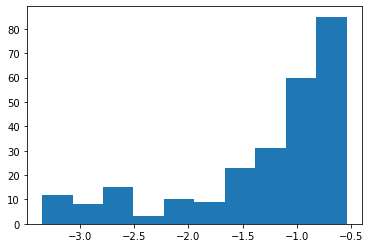

In [45]:
plt.hist(np.log10(contrast[contrast>0]))

In [50]:
df = pd.DataFrame(data = (dn, doy, tidi, hsn, az, zen, avg, rgb[:,0],rgb[:,1], rgb[:,2], sharp, contrast)).T
df.columns=['datenum','doy','tide','hsn','az','zen','avg','red','green','blue','sharp','contrast']
df['dts']=dts_list
df['dto']=dto_list
df['fnamec1']=c1list
df = df.round(decimals=3)
df.set_index('dto')
df.describe()

,datenum,doy,tide,hsn,az,zen,avg,red,green,blue,sharp,contrast
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000
mean,738268.618891,111.925113,-0.088209,-0.021662,183.209757,57.264405,115.776843,123.502972,114.888604,108.938999,0.000073,0.015863
std,26.186461,26.192710,0.851376,4.281132,73.579151,20.506855,24.782783,29.282994,24.625070,29.679630,0.000307,0.051471
min,738219.917000,63.000000,-1.720000,-16.672000,5.696000,20.112000,15.000000,15.000000,15.000000,15.000000,0.000000,0.000000
25%,738242.703000,86.000000,-0.869000,-3.172000,111.167750,41.126250,111.762750,114.922750,110.502000,90.195250,0.000000,0.000000
50%,738268.718500,112.000000,-0.109500,0.328000,187.280500,55.724000,120.266500,126.031000,119.685000,109.765000,0.000000,0.000000
75%,738293.630250,137.000000,0.692250,3.828000,254.062750,74.015000,129.184000,143.412250,128.192000,132.997250,0.000000,0.000000
max,738310.021000,154.000000,1.499000,6.828000,350.335000,116.596000,183.042000,205.456000,184.610000,191.177000,0.006000,0.288000


In [51]:
# remove dark images
df = df.drop(df[df['avg']< 80].index)
#df = df.drop(df[df['sharp']< 1e-5].index)
#df = df.drop(df[df['contrast']< 1e-3].index)

df.describe()

,datenum,doy,tide,hsn,az,zen,avg,red,green,blue,sharp,contrast
count,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000
mean,738269.547032,112.852587,-0.068975,-0.005634,182.470797,54.884041,121.354940,129.511244,120.418682,114.134952,0.000078,0.016951
std,25.989894,25.995703,0.852206,3.963048,71.180435,18.883205,12.016038,17.862530,12.019264,22.348450,0.000317,0.053034
min,738219.917000,63.000000,-1.720000,-16.672000,5.696000,20.112000,82.324000,77.149000,82.080000,69.953000,0.000000,0.000000
25%,738243.651250,87.000000,-0.858750,-3.172000,112.768000,40.086250,113.275500,117.561250,112.129750,94.919000,0.000000,0.000000
50%,738269.698000,113.000000,-0.069000,0.328000,184.985500,53.626500,121.504500,127.239000,120.865000,112.050000,0.000000,0.000000
75%,738293.953000,137.000000,0.708750,3.328000,250.874000,70.402750,129.601250,144.214750,128.643250,134.236750,0.000000,0.000000
max,738310.021000,154.000000,1.499000,6.828000,350.335000,115.534000,183.042000,205.456000,184.610000,191.177000,0.006000,0.288000


In [42]:
dfs = df.sample(6)
dfs

,datenum,doy,tide,hsn,az,zen,avg,red,green,blue,sharp,contrast,dts,dto,fnamec1
1283,738291.792,135.0,0.833,2.328,243.915,38.030,118.890,146.844,118.323,91.504,0.000,0.000,2021-05-15T19:00:00,2021-05-15 19:00:00,1621105200.c1.timex.jpg
1317,738292.917,136.0,0.287,5.328,278.831,70.536,116.291,127.024,116.028,105.819,0.000,0.177,2021-05-16T22:00:00,2021-05-16 22:00:00,1621202400.c1.timex.jpg
713,738262.583,106.0,-1.007,-2.672,120.428,47.187,111.545,108.518,111.133,114.983,0.000,0.000,2021-04-16T14:00:00,2021-04-16 14:00:00,1618581600.c1.timex.jpg
1279,738291.708,135.0,0.412,0.328,193.911,23.544,118.836,150.088,117.871,88.550,0.000,0.000,2021-05-15T17:00:00,2021-05-15 17:00:00,1621098000.c1.timex.jpg
461,738243.521,87.0,-0.254,-4.172,105.804,68.636,107.717,116.784,108.164,98.204,0.001,0.204,2021-03-28T12:30:00,2021-03-28 12:30:00,1616934600.c1.timex.jpg
517,738245.604,89.0,0.038,-2.172,132.358,48.455,130.101,121.190,128.111,141.002,0.000,0.000,2021-03-30T14:30:00,2021-03-30 14:30:00,1617114600.c1.timex.jpg


1621105200.c1.timex.jpg
1621105200.c2.timex.jpg
1621202400.c1.timex.jpg
1621202400.c2.timex.jpg
1618581600.c1.timex.jpg
1618581600.c2.timex.jpg
1621098000.c1.timex.jpg
1621098000.c2.timex.jpg
1616934600.c1.timex.jpg
1616934600.c2.timex.jpg
1617114600.c1.timex.jpg
1617114600.c2.timex.jpg


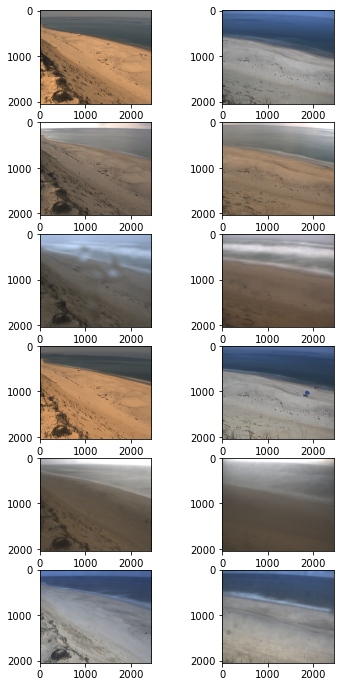

In [76]:
nsamp = 6
fig, axes = plt.subplots(nsamp,2, figsize=(6, 12) )
for i in range(0,nsamp):
   fn1 = dfs.iloc[i]['fnamec1']
   print(fn1)
   fn2 = fn1.replace('c1','c2')
   print(fn2)
   with Image.open(rdir+fn1) as img1:
        axes[i,0].imshow(img1)
   with Image.open(rdir+fn2) as img2:
        axes[i,1].imshow(img2)

In [70]:
axes.shape

(6, 2)